In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration des graphiques
sns.set_theme(style="whitegrid")

In [9]:
# 1. CHARGEMENT DU FICHIER EXCEL
# On définit le nom exact du fichier
file_path = 'get_around_delay_analysis.xlsx'

# On charge l'onglet contenant les données de location
# Note : Si cela affiche une erreur, vérifie si l'onglet s'appelle bien 'rentals_data'
df_delay = pd.read_excel(file_path, sheet_name='rentals_data')

# 2. CHARGEMENT DU FICHIER PRICING (qui est déjà en CSV lui)
df_price = pd.read_csv('get_around_pricing_project.csv').drop(columns=['Unnamed: 0'])

# Vérification
print("Colonnes de l'analyse des retards :")
print(df_delay.columns)
print("\nPremières lignes :")
display(df_delay.head())

Colonnes de l'analyse des retards :
Index(['rental_id', 'car_id', 'checkin_type', 'state',
       'delay_at_checkout_in_minutes', 'previous_ended_rental_id',
       'time_delta_with_previous_rental_in_minutes'],
      dtype='object')

Premières lignes :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [10]:
# 2. ANALYSE DES RETARDS (Delay Analysis)
# ==============================================================================

# Nettoyage : On ne garde que les locations terminées (ended) pour analyser les retards réels
df_ended = df_delay[df_delay['state'] == 'ended'].copy()

# 2.1 Quelle part des chauffeurs est en retard ?
late_proportion = (df_ended['delay_at_checkout_in_minutes'] > 0).mean()
print(f"\nProportion de retards au checkout : {late_proportion:.2%}")

# 2.2 Analyse par type de check-in (Mobile vs Connect)
delay_by_type = df_ended.groupby('checkin_type')['delay_at_checkout_in_minutes'].describe()
print("\nStatistiques des retards par type de check-in :")
print(delay_by_type)

# 2.3 Impact sur la location suivante
# On filtre les locations qui ont une location précédente identifiée (< 12h)
df_consecutive = df_delay[df_delay['previous_ended_rental_id'].notnull()].copy()

# On récupère le retard de la location précédente
delay_map = df_ended.set_index('rental_id')['delay_at_checkout_in_minutes'].to_dict()
df_consecutive['previous_delay'] = df_consecutive['previous_ended_rental_id'].map(delay_map)

# Une location est "impactée" si le retard précédent > le temps de battement prévu
df_consecutive['is_impacted'] = df_consecutive['previous_delay'] > df_consecutive['time_delta_with_previous_rental_in_minutes']

impact_rate = df_consecutive['is_impacted'].mean()
print(f"\nProportion de locations consécutives impactées par un retard : {impact_rate:.2%}")

# 2.4 Simulation des seuils (Thresholds)
# Objectif : Si on impose un délai X, combien de locations on perd vs combien de problèmes on résout ?
thresholds = [0, 30, 60, 120, 180, 240, 300, 360, 600]
sim_results = []

for t in thresholds:
    # Locations qu'on perd (car l'intervalle avec la précédente était < t)
    lost_rentals = (df_consecutive['time_delta_with_previous_rental_in_minutes'] < t).sum()
    
    # Problèmes résolus (on a évité une collision car le retard était <= t)
    # Note : Si retard > t, le problème n'est que partiellement résolu ou pas du tout
    solved_cases = (df_consecutive['is_impacted'] & (df_consecutive['previous_delay'] <= t)).sum()
    
    sim_results.append({
        'threshold_min': t,
        'lost_rentals': lost_rentals,
        'solved_cases': solved_cases
    })

df_sim = pd.DataFrame(sim_results)
print("\nSimulation de l'impact des seuils :")
print(df_sim)


Proportion de retards au checkout : 52.11%

Statistiques des retards par type de check-in :
                count       mean          std      min    25%   50%   75%  \
checkin_type                                                                
connect        3402.0 -43.627278   228.681964  -4276.0 -75.75  -9.0  32.0   
mobile        12943.0  88.215174  1108.296230 -22433.0 -26.00  14.0  77.0   

                  max  
checkin_type           
connect        1466.0  
mobile        71084.0  

Proportion de locations consécutives impactées par un retard : 11.84%

Simulation de l'impact des seuils :
   threshold_min  lost_rentals  solved_cases
0              0             0             0
1             30           279            68
2             60           401           102
3            120           666           147
4            180           870           167
5            240          1001           177
6            300          1106           189
7            360          1170    

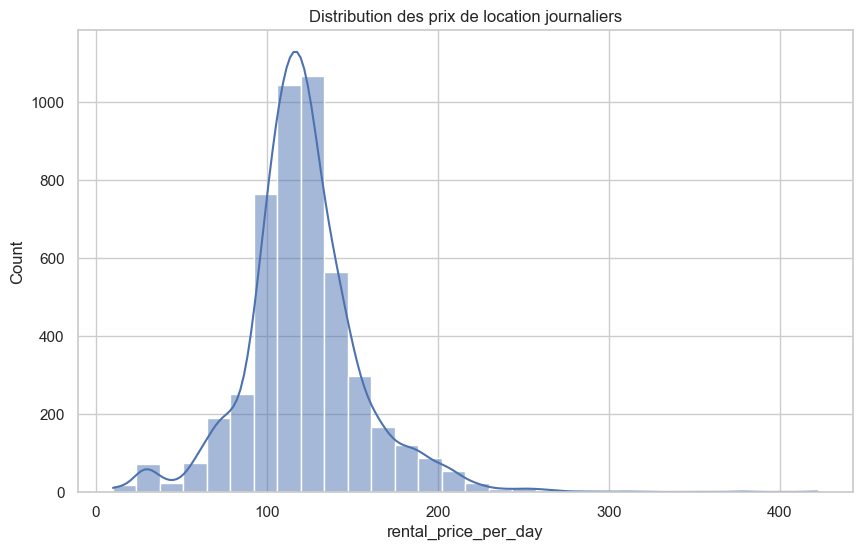

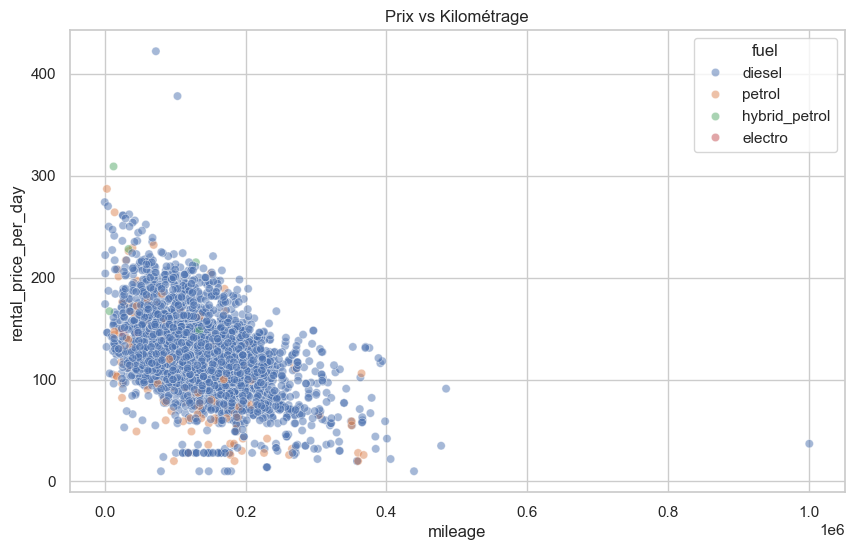

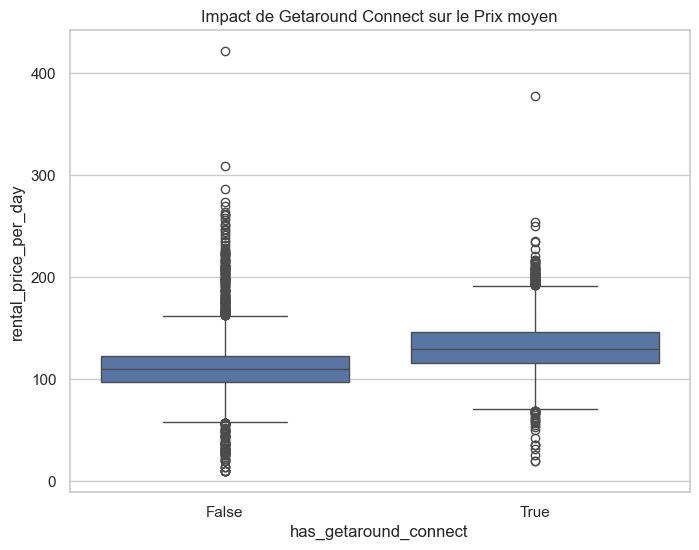

In [12]:
#3. ANALYSE DES PRIX (Pricing Analysis)
# ==============================================================================

# 3.1 Distribution du prix de location par jour
plt.figure(figsize=(10, 6))
sns.histplot(df_price['rental_price_per_day'], bins=30, kde=True)
plt.title('Distribution des prix de location journaliers')
plt.show()

# 3.2 Corrélation entre kilométrage et prix
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_price, x='mileage', y='rental_price_per_day', hue='fuel', alpha=0.5)
plt.title('Prix vs Kilométrage')
plt.show()

# 3.3 Impact de la technologie Connect sur le prix
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_price, x='has_getaround_connect', y='rental_price_per_day')
plt.title('Impact de Getaround Connect sur le Prix moyen')
plt.show()

# 4. CONCLUSIONS POUR LE DASHBOARD
# ==============================================================================
"""
Points clés à retenir :
1. Le "Connect" réduit naturellement les retards (processus plus fluide sans rdv physique).
2. 12% des locations en chaîne souffrent d'un retard du prédécesseur.
3. Un seuil de 120 min semble optimal : il capte la majorité des retards moyens 
   tout en limitant la perte de revenus.